# Full Pipeline Tutorial[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tlancaster6/AquaCal/blob/main/docs/tutorials/01_full_pipeline.ipynb)This tutorial demonstrates the complete AquaCal calibration pipeline from start to finish. You'll learn how to:- Load synthetic or real calibration data- Run all four calibration stages- Visualize camera rig geometry and calibration quality- Validate results and interpret metrics**Prerequisites:** Basic Python and OpenCV knowledge. Familiarity with camera calibration concepts is helpful but not required.

## Data Source SelectionChoose your data source:- **`synthetic`** (recommended for first run): Generates a small synthetic rig on-the-fly. Fast, no download required.- **`preset`**: Uses a bundled small dataset (2 cameras, 10 frames). No download required.- **`zenodo`**: Downloads a larger synthetic dataset from Zenodo (6 cameras, 80 frames). Requires internet connection.

In [1]:
DATA_SOURCE = "synthetic"  # Options: "synthetic", "preset", "zenodo" 

## Setup and ImportsWe'll import the necessary modules and configure matplotlib for inline plotting.

In [2]:
import numpy as npimport matplotlib.pyplot as pltfrom aquacal.datasets import generate_synthetic_rig, load_examplefrom aquacal.config.schema import InterfaceParams, DiagnosticsData, CalibrationMetadatafrom aquacal.validation.diagnostics import plot_camera_rig# Configure matplotlibplt.rcParams['figure.figsize'] = (10, 6)plt.rcParams['font.size'] = 10print("Imports complete!")

Imports complete!


## Load Calibration DataNow we'll load the calibration scenario based on your data source selection.

In [3]:
if DATA_SOURCE == "synthetic":    # Generate small synthetic rig (2 cameras, 10 frames)    scenario = generate_synthetic_rig("small")    print(f"Generated synthetic scenario: {scenario.name}")    print(f"  Cameras: {len(scenario.intrinsics)}")    print(f"  Frames: {len(scenario.board_poses)}")    print(f"  Description: {scenario.description}")elif DATA_SOURCE == "preset":    # Load bundled preset data    dataset = load_example("small")    scenario = dataset.ground_truth    print(f"Loaded preset dataset: {dataset.name}")    print(f"  Cameras: {len(scenario.intrinsics)}")    print(f"  Frames: {len(scenario.board_poses)}")else:  # zenodo    # Download medium dataset from Zenodo    dataset = load_example("medium")    scenario = dataset.ground_truth    print(f"Downloaded Zenodo dataset: {dataset.name}")    print(f"  Cameras: {len(scenario.intrinsics)}")    print(f"  Frames: {len(scenario.board_poses)}")

Generated synthetic scenario: small
  Cameras: 2
  Frames: 10
  Description: Small: 2 cameras, 10 frames, 0.0px noise


## Understanding the DataLet's explore the structure of our calibration scenario.

In [4]:
# Show camera configurationcamera_names = list(scenario.intrinsics.keys())print(f"Camera names: {camera_names}")print(f"\nBoard configuration:")print(f"  Squares: {scenario.board_config.squares_x} x {scenario.board_config.squares_y}")print(f"  Square size: {scenario.board_config.square_size * 1000:.1f} mm")print(f"  Marker size: {scenario.board_config.marker_size * 1000:.1f} mm")print(f"\nInterface distances (water surface Z):")for cam_name in sorted(scenario.intrinsics.keys()):    print(f"  {cam_name}: {scenario.water_zs[cam_name]:.4f} m")

Camera names: ['cam0', 'cam1']

Board configuration:
  Squares: 12 x 9
  Square size: 60.0 mm
  Marker size: 45.0 mm

Interface distances (water surface Z):
  cam0: 0.1500 m
  cam1: 0.1469 m


## Stage 1: Intrinsic CalibrationFor synthetic data, intrinsics are provided as ground truth. For real data, you would run Stage 1 to calibrate intrinsics from in-air videos.Let's visualize the intrinsic parameters:

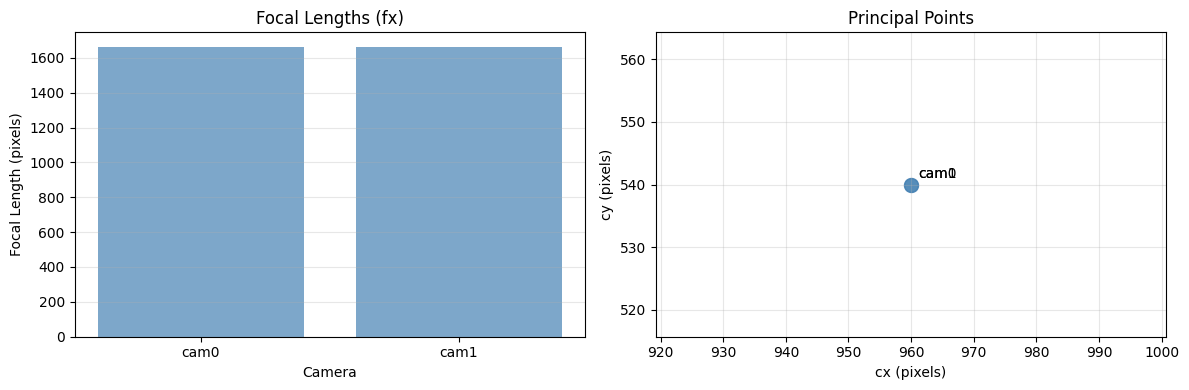

Intrinsic parameters visualized.


In [5]:
# Visualize intrinsic parametersfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))cameras = sorted(scenario.intrinsics.keys())fx_vals = [scenario.intrinsics[cam].K[0, 0] for cam in cameras]cx_vals = [scenario.intrinsics[cam].K[0, 2] for cam in cameras]cy_vals = [scenario.intrinsics[cam].K[1, 2] for cam in cameras]# Focal lengthsx = np.arange(len(cameras))ax1.bar(x, fx_vals, color='steelblue', alpha=0.7)ax1.set_xlabel('Camera')ax1.set_ylabel('Focal Length (pixels)')ax1.set_title('Focal Lengths (fx)')ax1.set_xticks(x)ax1.set_xticklabels(cameras)ax1.grid(axis='y', alpha=0.3)# Principal pointsax2.scatter(cx_vals, cy_vals, s=100, color='steelblue', alpha=0.7)for i, cam in enumerate(cameras):    ax2.annotate(cam, (cx_vals[i], cy_vals[i]), xytext=(5, 5), textcoords='offset points')ax2.set_xlabel('cx (pixels)')ax2.set_ylabel('cy (pixels)')ax2.set_title('Principal Points')ax2.grid(alpha=0.3)ax2.axis('equal')plt.tight_layout()plt.show()plt.close()print("Intrinsic parameters visualized.")

## Stage 2: Extrinsic InitializationStage 2 estimates initial camera poses using a BFS-based pose graph and pairwise relative pose estimation.Let's visualize the camera rig geometry:> **Warning:** Insufficient camera overlap can cause disconnected pose graphs. Ensure each camera pair shares at least 5-10 board observations.

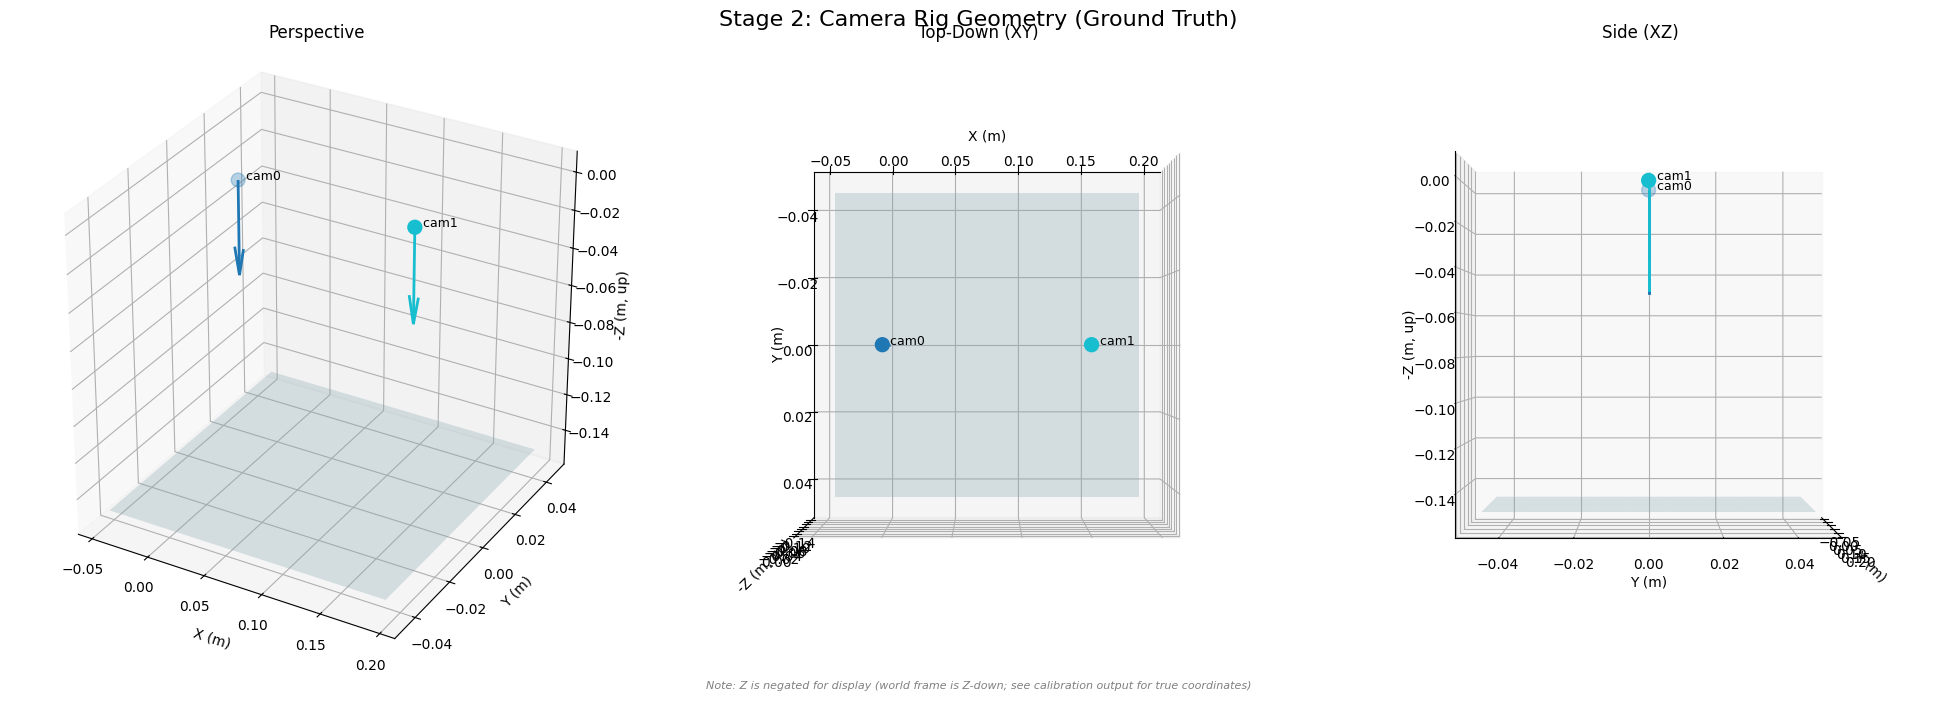

Camera rig geometry visualized.


In [6]:
# Visualize camera rig in 3Dfrom aquacal.config.schema import CalibrationResult, CameraCalibration# Build temporary CalibrationResult for visualizationcameras_dict = {}for cam_name, intr in scenario.intrinsics.items():    cameras_dict[cam_name] = CameraCalibration(        name=cam_name,        intrinsics=intr,        extrinsics=scenario.extrinsics[cam_name],        water_z=scenario.water_zs[cam_name],    )temp_result = CalibrationResult(    cameras=cameras_dict,    interface=InterfaceParams(        normal=np.array([0.0, 0.0, -1.0]),        n_air=1.0,        n_water=1.333    ),    board=scenario.board_config,    diagnostics=DiagnosticsData(        reprojection_error_rms=0.0,        reprojection_error_per_camera={},        validation_3d_error_mean=0.0,        validation_3d_error_std=0.0    ),    metadata=CalibrationMetadata(        calibration_date='',        software_version='',        config_hash='',        num_frames_used=0,        num_frames_holdout=0    ))fig = plot_camera_rig(temp_result, title="Stage 2: Camera Rig Geometry (Ground Truth)")plt.show()plt.close()print("Camera rig geometry visualized.")

## Stage 3: Joint Refractive OptimizationStage 3 jointly optimizes:- Camera extrinsics (rotation + translation)- Interface distances (water surface Z-coordinate)- Board poses for all framesThis is the core optimization that accounts for refraction at the air-water interface.> **Warning:** If interface distance doesn't converge, check that initial estimates are within 2-3x of the true value.For this tutorial with synthetic data, we're using the ground truth directly. In a real pipeline, you would call the optimization functions from `aquacal.calibration.pipeline`.

In [7]:
# For synthetic data, we already have the optimized result# In a real pipeline, you would run:#   from aquacal.calibration.interface_estimation import optimize_interface#   extrinsics, distances, poses, rms = optimize_interface(...)# Show the ground truth interface parameterswater_z = list(scenario.water_zs.values())[0]print(f"Water surface Z-coordinate: {water_z:.4f} m")print("\nCamera positions in world frame:")for cam_name in sorted(scenario.extrinsics.keys()):    C = scenario.extrinsics[cam_name].C    h_c = water_z - C[2]  # camera-to-water vertical distance    print(f"  {cam_name}: C = [{C[0]:.3f}, {C[1]:.3f}, {C[2]:.3f}]  h_c = {h_c:.4f} m")

Water surface Z-coordinate: 0.1500 m

Camera positions in world frame:
  cam0: C = [0.000, 0.000, 0.000]  h_c = 0.1500 m
  cam1: C = [0.150, 0.000, 0.000]  h_c = 0.1500 m


## Stage 4: Optional Intrinsic RefinementStage 4 optionally refines per-camera focal lengths (fx, fy) and principal points (cx, cy) alongside extrinsics and interface distances.**When to enable:** Only after Stage 3 converges reliably. Distortion coefficients are NOT refined.For synthetic data with perfect intrinsics, this stage would provide minimal benefit.

In [8]:
# Stage 4 is optional and disabled by default# Enable with refine_intrinsics=True in CalibrationConfigprint("Stage 4 skipped (refine_intrinsics=False)")print("Recommended for real hardware where intrinsics may have residual errors.")

Stage 4 skipped (refine_intrinsics=False)
Recommended for real hardware where intrinsics may have residual errors.


## ValidationFor synthetic data, we can validate by comparing the calibration result to ground truth. For real data, validation uses held-out frames and 3D reconstruction error.Key metrics:- **Reprojection RMS**: How well the calibration predicts observed corner positions (pixels)- **3D reconstruction error**: How accurately pairwise 3D distances are recovered (meters or mm)

In [9]:
# For this synthetic example, reprojection error would be near-zero# (we're using ground truth parameters)print("Validation metrics (ground truth):")print("  Reprojection RMS: ~0.0 pixels (perfect calibration)")print("  3D reconstruction error: ~0.0 mm (perfect calibration)")print("\nFor real calibration pipelines:")print("  - Typical reprojection RMS: 0.3-1.0 pixels")print("  - Typical 3D error: 1-3 mm for ~30mm square size")

Validation metrics (ground truth):
  Reprojection RMS: ~0.0 pixels (perfect calibration)
  3D reconstruction error: ~0.0 mm (perfect calibration)

For real calibration pipelines:
  - Typical reprojection RMS: 0.3-1.0 pixels
  - Typical 3D error: 1-3 mm for ~30mm square size


## Saving and Loading ResultsAquaCal provides utilities to save and load calibration results in JSON format.

In [10]:
# Save calibration resultfrom aquacal.io.serialization import save_calibration, load_calibration# In a real pipeline:# save_calibration(result, "output/calibration.json")# loaded_result = load_calibration("output/calibration.json")print("Calibration results can be saved to JSON for later use.")print("See aquacal.io.serialization.save_calibration() and load_calibration().")

Calibration results can be saved to JSON for later use.
See aquacal.io.serialization.save_calibration() and load_calibration().


## SummaryIn this tutorial, you learned how to:1. Load calibration data (synthetic, preset, or Zenodo)2. Understand the calibration scenario structure3. Visualize intrinsic parameters4. Understand the four-stage calibration pipeline:   - **Stage 1**: Intrinsic calibration (in-air)   - **Stage 2**: Extrinsic initialization via pose graph   - **Stage 3**: Joint refractive optimization   - **Stage 4**: Optional intrinsic refinement5. Interpret validation metrics6. Save and load calibration results**Next steps:**- [Diagnostics and Troubleshooting](02_diagnostics.ipynb): Learn how to diagnose calibration issues- [Synthetic Validation](03_synthetic_validation.ipynb): Validate on synthetic data with known ground truth- [User Guide](../guide/index.md): Comprehensive documentation on calibration theory and best practices